## 🖼️ Framing the problem and looking at the big picture
1. We are in the position of a bank lending money to it's customers. The objective is to classify customers into those who will default (fail to repay their debt) and those who will not. 
2. Let's pretend the last solution to this task was manual and was done by experts case by case. This way, we have to start from scratch.
3. This will be a classic supervised (we are working with customer labels) classification (we try to split our customers into two groups) task and will probably be implemented to function online.
4. We will measure the performance through Gini coefficient, a measure derived from the area under the Receiver Operating Characteristic (ROC) curve. This curve visualizes the tradeoff between false positives and false negatives at different thresholds.

# 📦 Imports

In [2]:
# pandas
import pandas as pd

# matplotlib
import matplotlib.pyplot as plt

# numpy
import numpy as np

# seaborn
import seaborn as sns

# chardet
import chardet
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn._config import set_config
set_config(display="diagram")


In [3]:
data1 = pd.read_csv("data/CreditData_labeled1.csv")
data2 = pd.read_csv("data/CreditData_labeled2.csv")

data = pd.concat([data1, data2], ignore_index=True)

path = "data/columns_description.csv"
with open(path, 'rb') as f:
    rawdata = f.read()
result = chardet.detect(rawdata)
encoding = result['encoding']

unlabeled_data = data[data["TARGET"].isna()]
data = data[data["TARGET"].notna()]

col_descriptions = pd.read_csv(path, encoding=encoding)
col_descriptions = col_descriptions.drop(columns=['Unnamed: 0'])

# 🔎 EDA

## Exploring features

## Exploring missing values

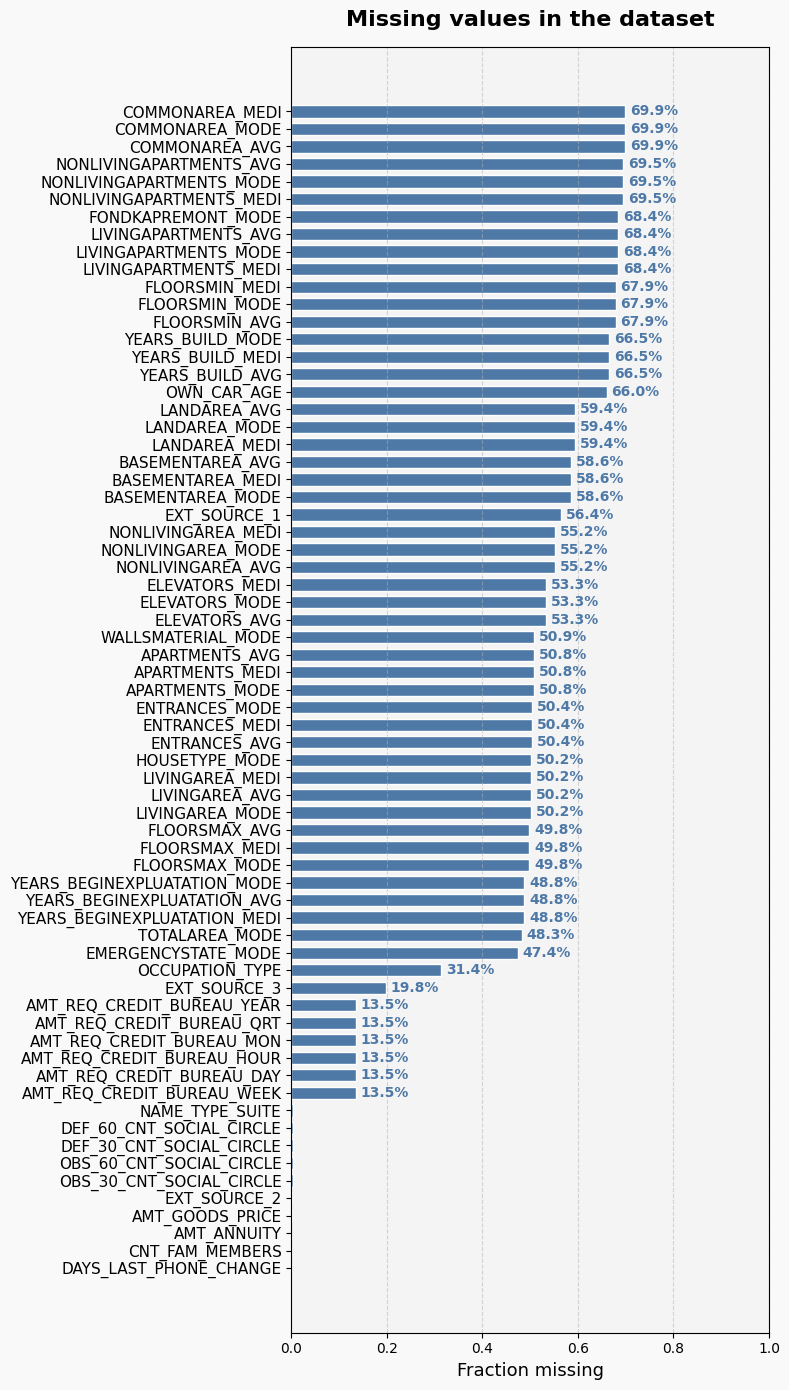

In [4]:
na_count = data.isna().sum().sort_values() / len(data)
na_count = na_count[na_count > 0]

fig, ax = plt.subplots(figsize=(8, 14), layout='tight')

bars = ax.barh(
    y=na_count.index,
    width=na_count.values.tolist(),
    color="#4E79A7",
    edgecolor='white',
    height=0.7
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    if width > 0.01:
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f"{width:.1%}", va='center', ha='left', fontsize=10, color="#4E79A7", fontweight='bold')

ax.set_xlabel("Fraction missing", fontsize=13)
ax.set_title("Missing values in the dataset", fontsize=16, fontweight='bold', pad=15)
ax.set_xlim(0, 1)
ax.set_facecolor('#f4f4f4')
fig.patch.set_facecolor('#f9f9f9')
ax.xaxis.grid(True, linestyle='--', alpha=0.5)
ax.tick_params(axis='y', labelsize=11)
plt.tight_layout()
plt.show()

### Checking MAR and MNAR

In [5]:
data_default_true = data[data["TARGET"]==1]
data_default_false = data[data["TARGET"]==0]

default_true_na_count = data_default_true.isna().sum().sort_values()/len(data_default_true)
default_false_na_count = data_default_false.isna().sum().sort_values()/len(data_default_false)


na_data = pd.concat([default_true_na_count, default_false_na_count], axis=1)
na_data.columns = ["TARGET_True", "TARGET_False"]
na_data = na_data[na_data["TARGET_True"]+na_data["TARGET_True"] > 0]

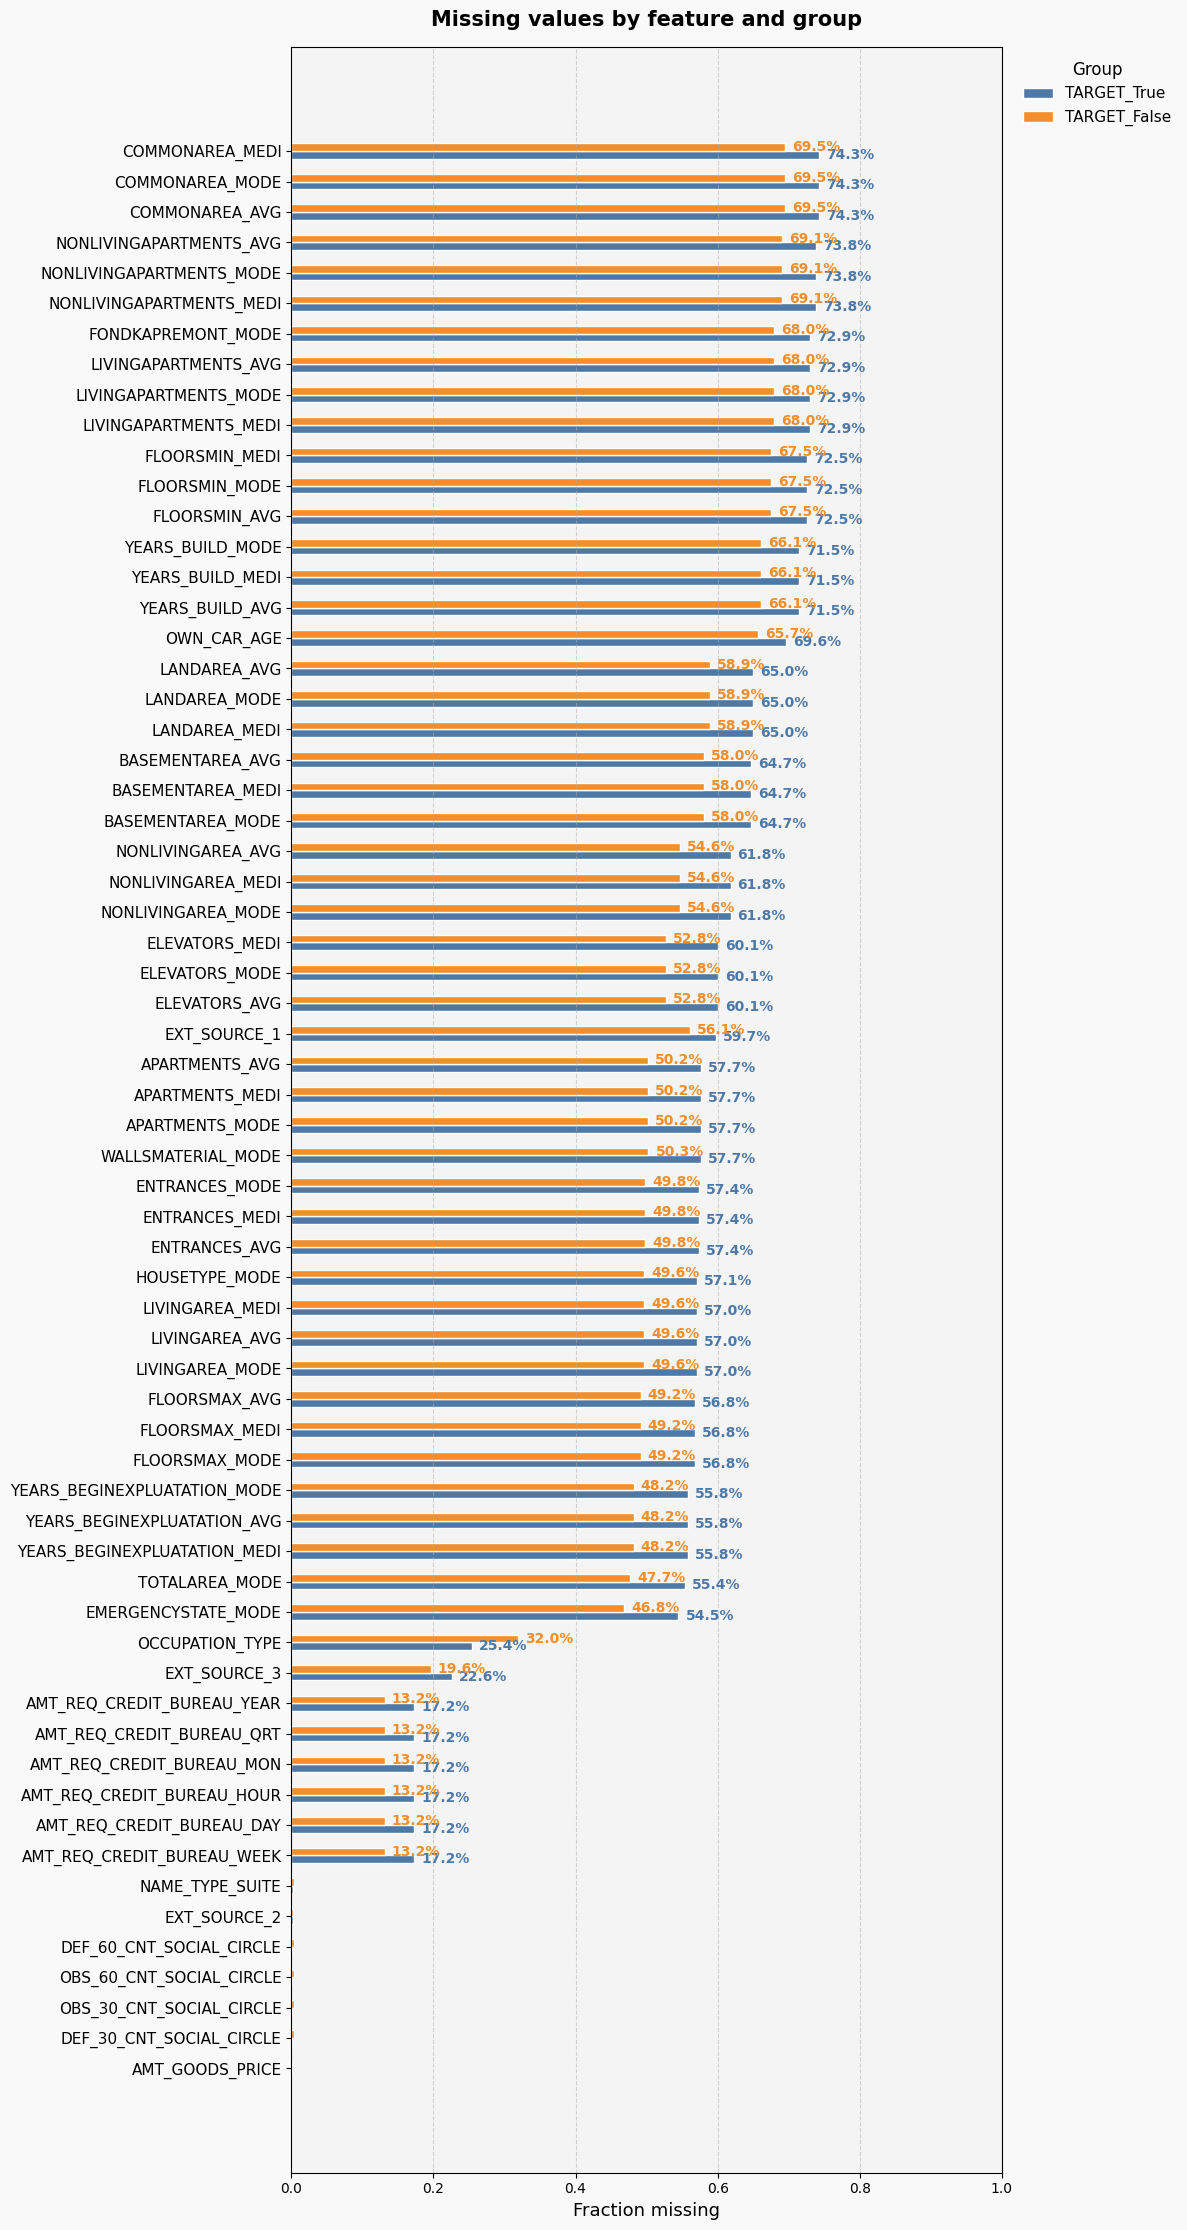

In [6]:
groups = na_data.columns
features = na_data.index.tolist()
n_groups = len(groups)
n_features = len(features)
width = 0.25

y = np.arange(n_features)
# Use more distinct colors
colors = ['#4E79A7', '#F28E2B']

fig, ax = plt.subplots(figsize=(12, max(8, n_features * 0.35)), layout='tight')
fig.patch.set_facecolor('#f9f9f9')
ax.set_facecolor('#f4f4f4')

for i, (group, color) in enumerate(zip(groups, colors)):
    offset = (i - (n_groups-1)/2) * width
    rects = ax.barh(y + offset, na_data[group], height=width, label=group, color=color, edgecolor='white')
    for yi, value in enumerate(na_data[group]):
        if value > 0.01:
            ax.text(value + 0.01, yi + offset, f"{value:.1%}", va='center', ha='left', fontsize=10, color=color, fontweight='bold')

ax.set_yticks(y)
ax.set_yticklabels(features, fontsize=11)
ax.set_xlabel("Fraction missing", fontsize=13)
ax.set_xlim(0, 1)
ax.xaxis.grid(True, linestyle='--', alpha=0.5)
ax.legend(title="Group", loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False, fontsize=11, title_fontsize=12)
ax.set_title("Missing values by feature and group", fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

In [7]:
# Columns with no NAs
perfect_data = data.drop(columns=na_count[na_count==0].index)


In [8]:

# We will extract categorical features
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
data_categorical = data[categorical_features]
onehotencoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
data_categorical_encoded = onehotencoder.fit_transform(data_categorical)
data_categorical_encoded = pd.DataFrame(data_categorical_encoded, columns=onehotencoder.get_feature_names_out(categorical_features))
len(data_categorical["ORGANIZATION_TYPE"].value_counts())

58

## Outliers

## Fooling around cause i'm impatient

Precision: 0.41379310344827586
Recall: 0.010935601458080195
F1 Score: 0.021308079313406333


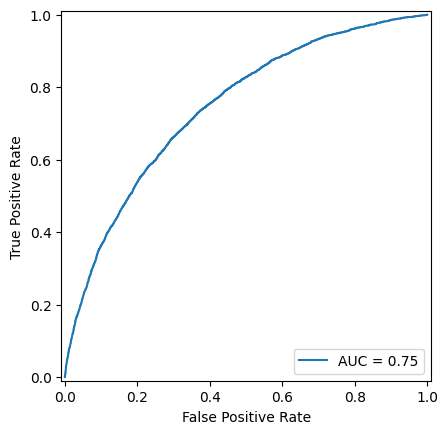

In [9]:
just_for_fun = data.drop(categorical_features,axis=1)
just_for_fun = pd.concat([just_for_fun, data_categorical_encoded], axis=1)

X = just_for_fun.drop(["TARGET"], axis = 1)
y = just_for_fun["TARGET"]


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)


pajpa = make_pipeline(SimpleImputer(), 
                      StandardScaler(), 
                      LogisticRegression())

pajpa.fit(X_train, y_train)
accuracy = pajpa.score(X_test, y_test)

# ROC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
y_scores = pajpa.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
# GINI
from sklearn.metrics import roc_auc_score
gini = 2 * roc_auc - 1

# PRECISION
from sklearn.metrics import precision_score
precision = precision_score(y_test, pajpa.predict(X_test))
print(f"Precision: {precision}")

# RECALL
from sklearn.metrics import recall_score
recall = recall_score(y_test, pajpa.predict(X_test))
print(f"Recall: {recall}")

# F1 SCORE
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pajpa.predict(X_test))
print(f"F1 Score: {f1}")


In [10]:
pajpa

,steps,"[('simpleimputer', ...), ('standardscaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True
